Device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.6MB/s]


Running No Regularization...
Running L2 Regularization...
Running Dropout...


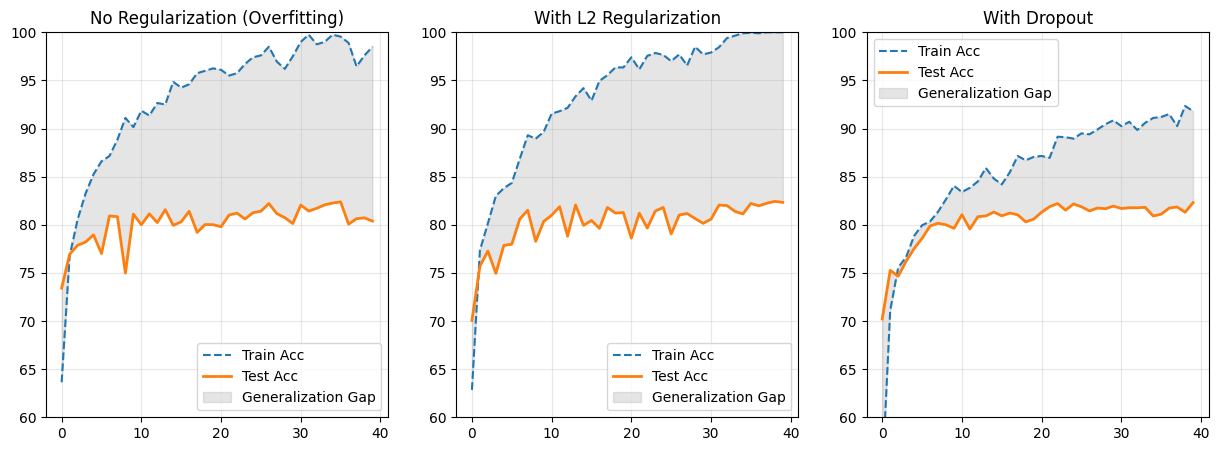

In [1]:
# ======================================================================================
# EXTENSION EXPERIMENT 1: REGULARIZATION TECHNIQUES (L2 & DROPOUT)
# ======================================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 1. Setup Data (Lấy chỉ 2000 ảnh train để DỄ BỊ OVERFIT)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Lấy mẫu ngẫu nhiên 2000 ảnh
indices = np.random.choice(len(full_train_set), 2000, replace=False)
train_subset = Subset(full_train_set, indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

# 2. Define Models
# Model thường (dễ overfit)
class BaseMLP(nn.Module):
    def __init__(self, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5) # Dropout 50%
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        if self.use_dropout: x = self.dropout(x)
        x = self.relu(self.fc2(x))
        if self.use_dropout: x = self.dropout(x)
        x = self.fc3(x)
        return x

# 3. Training Loop
def train_experiment(name, model, weight_decay=0.0, epochs=40):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    train_accs, test_accs = [], []
    
    print(f"Running {name}...")
    for epoch in range(epochs):
        model.train()
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        # Eval
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        train_accs.append(100 * correct_train / total_train)
        test_accs.append(100 * correct_test / total_test)
        
    return train_accs, test_accs

# 4. Run Comparisons
# Case 1: No Regularization (Sẽ bị Overfit: Train cao, Test thấp)
model_base = BaseMLP(use_dropout=False).to(device)
train_base, test_base = train_experiment("No Regularization", model_base, weight_decay=0.0)

# Case 2: L2 Regularization (Weight Decay)
model_l2 = BaseMLP(use_dropout=False).to(device)
train_l2, test_l2 = train_experiment("L2 Regularization", model_l2, weight_decay=1e-4) # lambda

# Case 3: Dropout
model_drop = BaseMLP(use_dropout=True).to(device)
train_drop, test_drop = train_experiment("Dropout", model_drop, weight_decay=0.0)

# 5. Plotting (Vẽ Gap giữa Train và Test)
plt.figure(figsize=(15, 5))

def plot_gap(ax, train_acc, test_acc, title):
    ax.plot(train_acc, label='Train Acc', linestyle='--')
    ax.plot(test_acc, label='Test Acc', linewidth=2)
    ax.fill_between(range(len(train_acc)), train_acc, test_acc, alpha=0.2, color='gray', label='Generalization Gap')
    ax.set_title(title)
    ax.set_ylim(60, 100)
    ax.legend()
    ax.grid(True, alpha=0.3)

ax1 = plt.subplot(1, 3, 1)
plot_gap(ax1, train_base, test_base, "No Regularization (Overfitting)")

ax2 = plt.subplot(1, 3, 2)
plot_gap(ax2, train_l2, test_l2, "With L2 Regularization")

ax3 = plt.subplot(1, 3, 3)
plot_gap(ax3, train_drop, test_drop, "With Dropout")

plt.savefig('regularization_comparison.png', dpi=300)
plt.show()